In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
import re
from coarsening import RegexDict
import shutil

# %matplotlib widget 
%matplotlib inline

dir_setup = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test'
oasisfiles = glob.glob(os.path.join(dir_setup,'input/oasis3/*.nc'))
dir_out = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_109x106'

griddata = xr.load_dataset( os.path.join(dir_setup,'input/oasis3/grids.nc') )
maskdata = xr.load_dataset( os.path.join(dir_setup,'input/oasis3/masks.nc') )

In [8]:
# copy clm grid to the oasis input folder
shutil.copy(glob.glob(os.path.join(dir_out,'input_clm/griddata*'))[0], os.path.join(dir_out,'input_oas/clmgrid.nc') )
                                                                                

'/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_109x106/input_oas/clmgrid.nc'

In [7]:
glob.glob(os.path.join(dir_out,'input_clm/griddata*'))[0]

'/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_109x106/input_clm/griddata_cordex_109x106.nc'

In [2]:
oasisfiles

['/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/oasis3/rmp_gpfl_to_gclm_BILINEA.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/oasis3/masks.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/oasis3/rmp_gclm_to_gpfl_DISTWGT.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/oasis3/rmp_gcos_to_gclm_BILINEA.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/oasis3/rmp_gclm_to_gcos_DISTWGT.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/oasis3/grids.nc']

In [47]:
griddata

<xarray.Dataset>
Dimensions:   (y_gcos: 424, x_gcos: 436, crn_gcos: 4, y_gpfl: 424, x_gpfl: 436, crn_gpfl: 4, y_gclm: 1, x_gclm: 184864, crn_gclm: 4)
Dimensions without coordinates: y_gcos, x_gcos, crn_gcos, y_gpfl, x_gpfl, crn_gpfl, y_gclm, x_gclm, crn_gclm
Data variables:
    gcos.lon  (y_gcos, x_gcos) float64 -10.37 -10.26 -10.15 ... 37.37 37.48
    gcos.lat  (y_gcos, x_gcos) float64 21.14 21.14 21.14 ... 67.67 67.67 67.67
    gcos.clo  (crn_gcos, y_gcos, x_gcos) float64 -10.43 -10.32 ... 37.31 37.42
    gcos.cla  (crn_gcos, y_gcos, x_gcos) float64 21.09 21.09 ... 67.73 67.73
    gpfl.lon  (y_gpfl, x_gpfl) float64 -10.37 -10.26 -10.15 ... 37.37 37.48
    gpfl.lat  (y_gpfl, x_gpfl) float64 21.14 21.14 21.14 ... 67.67 67.67 67.67
    gpfl.clo  (crn_gpfl, y_gpfl, x_gpfl) float64 -10.32 -10.21 ... 37.31 37.42
    gpfl.cla  (crn_gpfl, y_gpfl, x_gpfl) float64 21.09 21.09 ... 67.62 67.62
    gclm.lon  (y_gclm, x_gclm) float64 -10.37 -10.26 -10.15 ... 37.37 37.48
    gclm.lat  (y_gclm, x_gclm) float64 21.14 21.14 21.14 ... 67.67 67.67 67.67
    gclm.clo  (crn_gclm, y_gclm, x_gclm) float64 -10.43 -10.32 ... 37.31 37.42
    gclm.cla  (crn_gclm, y_gclm, x_gclm) float64 21.09 21.09 ... 67.73 67.73

In [9]:
griddata['crn_gpfl']

<xarray.DataArray 'crn_gpfl' (crn_gpfl: 4)>
array([0, 1, 2, 3])
Dimensions without coordinates: crn_gpfl

In [3]:
maskdata

<xarray.Dataset>
Dimensions:   (y_gcos: 424, x_gcos: 436, y_gpfl: 424, x_gpfl: 436, y_gclm: 1, x_gclm: 184864)
Dimensions without coordinates: y_gcos, x_gcos, y_gpfl, x_gpfl, y_gclm, x_gclm
Data variables:
    gcos.msk  (y_gcos, x_gcos) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    gpfl.msk  (y_gpfl, x_gpfl) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    gclm.msk  (y_gclm, x_gclm) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

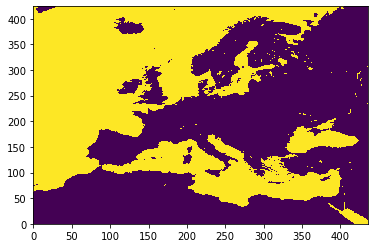

In [4]:
plt.pcolormesh(maskdata['gpfl.msk'])

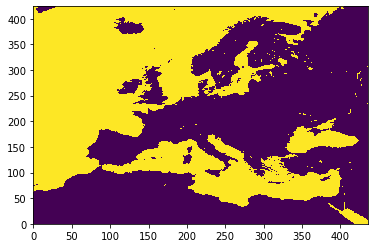

In [18]:
n_coarse = 4

dict_fn = RegexDict({'NUMLON':'div_n','LONGXY':'centre','LATIXY':'centre',
           'LANDMASK':'median_round','LANDFRAC':'median_round',
           'LONE':'upper_corner','LATN':'upper_corner','LONW':'lower_corner','LATS':'lower_corner',
           'AREA':'sum_cells','TOPO':'mean_cells','LANDFRAC_PFT':'median_round','PFTDATA_MASK':'median_round',
           'SOIL_COLOR':'most_common','PCT_(.*)':'mean_cells','MONTHLY_(.*)':'mean_cells'})

list_coarsen = [griddata,maskdata]
dict_data_coarse = {'fracdata':None,'griddata':None,'topodata':None,'surfdata':None}

for data_,name_ in zip(list_coarsen,dict_data_coarse.keys()):

    print('coarsening %s' % name_)

    data_coarse = data_.coarsen(dim={'lsmlat':n_coarse,'lsmlon':n_coarse},boundary='exact').median()
    data_regions = data_.coarsen(dim={'lsmlat':n_coarse,'lsmlon':n_coarse},boundary='exact').construct(lsmlon=("lsmlon", "x_fine"), lsmlat=("lsmlat", "y_fine"))

    for var_ in data_regions.keys():

        fn_agg = dict_fn.get_matching(var_)    
        if fn_agg is not None:
            data_coarse[var_] = locals()[fn_agg](data_regions[var_])

    
    dict_data_coarse[name_] = data_coarse